# Build a full catalogue of datasets

While there is an [official catalogue of all surveys](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/124049), 
there is no way to download all files in one go. 
I had to manually download the metadata records (ID, title, file location) for the surveys in batches of 100 (the maximum the website permitted). This lead to 16 CSV files with the information I need.  

This notebook builds a unified catalogue of survey IDs, titles, and download links. It will also query the server and try to figure out the disk space required for the surveys.

In [15]:
import glob
import pandas as pd
import requests
import matplotlib.pyplot as plt
import tqdm

## Combine the metadata records

In [2]:
tmp = []
for fname in glob.glob("../metadata/metadata_records*.csv"):
    print(f"Reading file: {fname}")
    tmp.append(pd.read_csv(fname, header=0, escapechar='\\', encoding='utf-8'))
catalogue = pd.concat(tmp)
print(f"\nUnique entries in the catalogue: {catalogue.uuid.unique().size}")

Reading file: ../metadata/metadata_records(13).csv
Reading file: ../metadata/metadata_records.csv
Reading file: ../metadata/metadata_records(12).csv
Reading file: ../metadata/metadata_records(15).csv
Reading file: ../metadata/metadata_records(4).csv
Reading file: ../metadata/metadata_records(14).csv
Reading file: ../metadata/metadata_records(1).csv
Reading file: ../metadata/metadata_records(11).csv
Reading file: ../metadata/metadata_records(16).csv
Reading file: ../metadata/metadata_records(5).csv
Reading file: ../metadata/metadata_records(9).csv
Reading file: ../metadata/metadata_records(8).csv
Reading file: ../metadata/metadata_records(3).csv
Reading file: ../metadata/metadata_records(7).csv
Reading file: ../metadata/metadata_records(6).csv
Reading file: ../metadata/metadata_records(2).csv
Reading file: ../metadata/metadata_records(10).csv

Unique entries in the catalogue: 1631


In [3]:
catalogue.head()

,uuid,eCatId,Title,Abstract,MetadataScope,ParentMetadata,CitationDate,Purpose,Status,Keyword,...,DataStorageLink,Lineage,SourceDescription,ServiceType,CouplingType,OperationName,DistributedComputingPlatform,OperationDescription,DistributionFormat,AssociatedResourcesLink
0,beeb5189-9f86-4961-8621-f162767ec418,124479,"Alton Downs Gravity (P196240), gravity point data",Gravity data measures small changes in gravity...,"dataset~Alton Downs Gravity (P196240), gravity...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Alton Downs Gravity (P196240), gravity po...","This Alton Downs Gravity (P196240), gravity po...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ef420cf3-f391-4d10-bfe6-bdae88b5f7f6,124509,"Dalhousie Gravity 1963D9 (P196340), gravity po...",Gravity data measures small changes in gravity...,"dataset~Dalhousie Gravity 1963D9 (P196340), gr...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Dalhousie Gravity 1963D9 (P196340), gravi...","This Dalhousie Gravity 1963D9 (P196340), gravi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bb919033-23b3-44c9-9a07-60755a6e7141,124488,"Helicopter Gravity (Contract) (P196304), gravi...",Gravity data measures small changes in gravity...,dataset~Helicopter Gravity (Contract) (P196304...,NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Helicopter Gravity (Contract) (P196304), ...","This Helicopter Gravity (Contract) (P196304), ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0d8c4584-07e0-4fa2-8b7a-699dcb2af3da,124464,"Renmark, Pata, Wanbi Gravity (P196163), gravit...",Gravity data measures small changes in gravity...,"dataset~Renmark, Pata, Wanbi Gravity (P196163)...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Renmark, Pata, Wanbi Gravity (P196163), g...","This Renmark, Pata, Wanbi Gravity (P196163), g...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60bc1b84-59d7-4ecf-a11d-e48f4a6a9ae8,124513,"Augusta Moora Gravity (P196346), gravity point...",Gravity data measures small changes in gravity...,"dataset~Augusta Moora Gravity (P196346), gravi...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Augusta Moora Gravity (P196346), gravity ...","This Augusta Moora Gravity (P196346), gravity ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
catalogue.columns

Index(['uuid', 'eCatId', 'Title', 'Abstract', 'MetadataScope',
       'ParentMetadata', 'CitationDate', 'Purpose', 'Status', 'Keyword',
       'Keyword-Thesaurus', 'TopicCategory', 'MaintenanceFrequency',
       'ResponsibleParty', 'ResourceContact', 'MetadataContact',
       'GeographicalExtent', 'SpatialExtentDescription',
       'HorizontalSpatialReferenceSystem', 'VerticalExtent', 'VerticalCRS',
       'TemporalExtent', 'ResourceLegalConstraints', 'UseLimitations',
       'DistributionLink', 'DataStorageLink', 'Lineage', 'SourceDescription',
       'ServiceType', 'CouplingType', 'OperationName',
       'DistributedComputingPlatform', 'OperationDescription',
       'DistributionFormat', 'AssociatedResourcesLink'],
      dtype='object')

In [5]:
print(catalogue.HorizontalSpatialReferenceSystem.unique())
print(catalogue.HorizontalSpatialReferenceSystem.describe())

['GDA94 (EPSG:4283)' 'WGS 84 (geocentric) (EPSG:4328)']
count                  1631
unique                    2
top       GDA94 (EPSG:4283)
freq                   1624
Name: HorizontalSpatialReferenceSystem, dtype: object


In [6]:
print(catalogue.VerticalCRS.unique())
print(catalogue.VerticalCRS.describe())

[nan]
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: VerticalCRS, dtype: float64


## Get the download size of each survey

In [8]:
baseurl = "http://dapds00.nci.org.au/thredds/fileServer/"

In [9]:
catalogue["DownloadLink"] = baseurl + catalogue.DataStorageLink.str[8:]
catalogue.DownloadLink.values[0]

'http://dapds00.nci.org.au/thredds/fileServer/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/GA/point/P196240/P196240-point-gravity.nc'

In [11]:
nbytes = []
for url in tqdm.tqdm(catalogue.DownloadLink.values):
    nbytes.append(int(requests.get(url, stream=True).headers["Content-length"]))

100%|██████████| 1631/1631 [20:09<00:00,  1.35it/s] 


In [13]:
catalogue["SizeBytes"] = nbytes

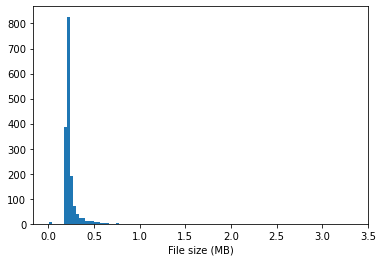

In [21]:
plt.figure()
plt.hist(catalogue.SizeBytes * 1e-6, bins=100)
plt.xlabel("File size (MB)")
plt.show()

In [22]:
print(catalogue.SizeBytes.mean() * 1e-6, catalogue.SizeBytes.max() * 1e-6)

0.23750367811158796 3.3358079999999997


In [25]:
print(f"Total download size: {catalogue.SizeBytes.sum() * 1e-6} MB")

Total download size: 387.368499 MB


## Export to CSV

In [27]:
catalogue.to_csv("../metadata/records.csv", index=False)